In [24]:
import numpy as np
import pandas as pd
import pymc as pm

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_linnerud

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

np.random.seed(42)

# Question 1

For a binary outcome dataset, I am using the Titanic dataset from seaborn.

The dataset contains information about the Titanic passengers and whether they survived or not.

In [25]:
# Load the Titanic dataset
data = sns.load_dataset("titanic")
# Drop rows with missing values in key columns
data = data.dropna(subset=["age", "fare", "survived"])

# Use "age" and "fare" as predictors and "survived" as the binary outcome
X = data[["age", "fare"]].values
y = data["survived"].values

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
p = X_scaled.shape[1]  # number of predictors

# Define the Bayesian logistic regression model
with pm.Model() as logistic_model:
    # Priors for coefficients (using independent normals)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=p)
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # Linear predictor
    mu = intercept + pm.math.dot(X_scaled, betas)

    # Logit link function (sigmoid transformation)
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    # Likelihood: the binary outcome is modeled as Bernoulli distributed
    likelihood = pm.Bernoulli("likelihood", p=theta, observed=y)

    # Run MCMC sampling (using 2000 samples and 1000 tuning steps)
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Output()

           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  -0.25  0.08   -0.41    -0.11        0.0      0.0   3548.84   
betas[1]   0.91  0.14    0.64     1.18        0.0      0.0   3382.72   
intercept -0.34  0.08   -0.50    -0.19        0.0      0.0   3642.39   

           ess_tail  r_hat  
betas[0]    3016.41    1.0  
betas[1]    2283.62    1.0  
intercept   2762.76    1.0  


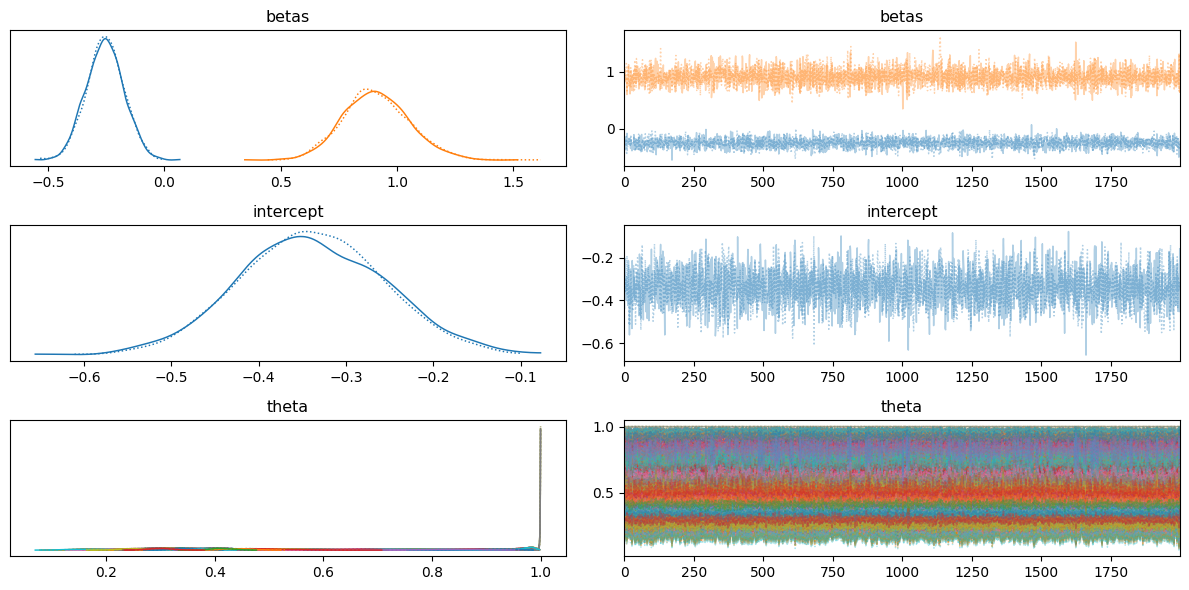

In [26]:
# Posterior analysis and diagnostics using ArviZ

# Summary statistics, including R-hat and effective sample size
summary_stats = az.summary(trace,var_names=['betas', 'intercept'], round_to=2)
print(summary_stats)

# Trace plots for visual inspection of the chains
az.plot_trace(trace)
plt.tight_layout()
plt.show()

#### Bayesian Posterior Analysis

We see that $\mathbb{E}[\beta_0] = -0.25, \mathcal{sd}(\beta_0) = 0.08$, with 94% credible inverval of $[-0.4, 0.11]$.

We see that $\mathbb{E}[\beta_1] = 0.91, \mathcal{sd}(\beta_1) = 0.14$, with 94% credible inverval of $[0.65, 1.18]$.

We see that $\mathbb{E}[\text{intercept}] = -0.34, \mathcal{sd}(\text{intercept}) = 0.08$, with 94% credible inverval of $[-0.5, -0.19]$.



#### MCMC Diagnostics

From the summary table, we know see that `r_hat` for all variables are close to 1.0. This indicates that between-chain variance and within-chain variance are similar, which suggests good convergence.

Also, we see that `ess_bulk` and `ess_tail`are above 2000 for all variables, which indicates a large effective sample size. This tells us that there is low autocorrelation in the chains and that the posterior estiamtes are based on many independent draws.

# Question 2

For this question, I used the Linnerud dataset, which consists of three exercise (data) and three physiological (target) variables collected from twenty middle-aged men in a fitness club.

In [27]:
# Load the Linnerud dataset
linnerud = load_linnerud()
X_full = linnerud.data    # Full predictors: shape (20, 3)
y_full = linnerud.target  # Full outcomes: shape (20, 3)

# Standardize the predictors for improved sampling efficiency
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)


## 3 Scenarios to consider

1. Full dataset (n=20, p=3, m=3)
2. Downsample observations (n=10, p=3, m=3)
3. Reduce predictors and outcomes (n=20, p=2, m=2)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/subtensor.py:2585: RuntimeWarning: invalid value 
encountered in add
  np.add.at(x, idx, y)

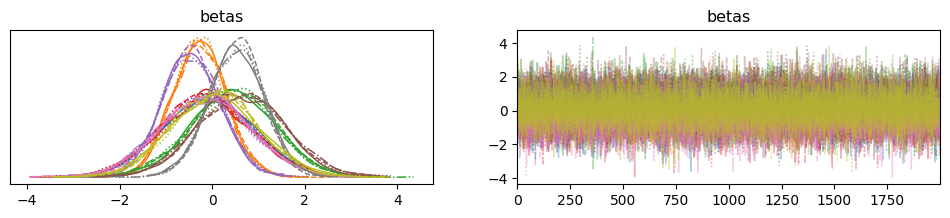

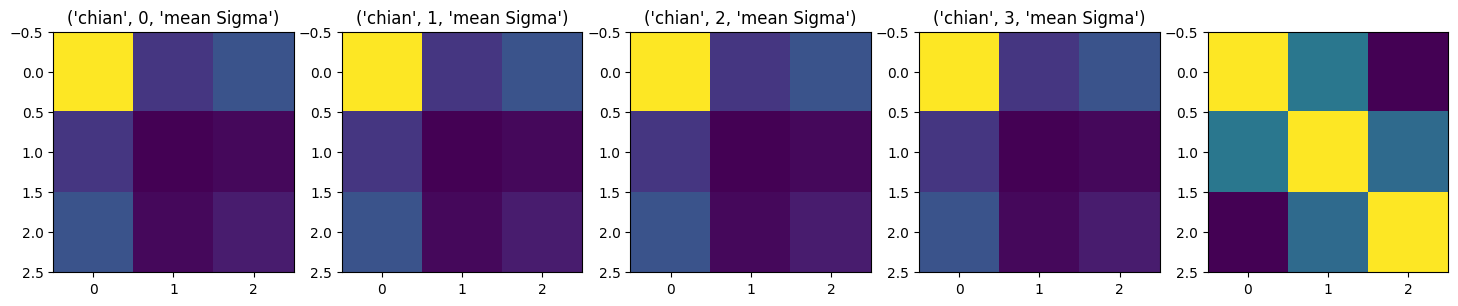

In [28]:
# Scenario 1: Full dataset (n=20, p=3, m=3)
n1 = 20
p1 = 3
m1 = 3
indices1 = np.arange(n1)
X1 = X_full_scaled[indices1, :]
y1 = y_full[indices1, :]
a_cov = np.cov(X1.T)

n, p, m = n1, p1, m1
X = X1
y = y1

with pm.Model() as model:
    # Prior for the Cholesky factor of the residual covariance matrix using an LKJ prior.
    # Note: We use the packed representation.
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                       sd_dist=pm.Exponential.dist(1.0, shape=m),
                                       compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    # Prior for the regression coefficients (p x m)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Deterministic reconstruction of the covariance matrix (for diagnostics)
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))

    # Likelihood: outcomes modeled as multivariate normal with mean = X @ betas and covariance from L
    y_obs = pm.MvNormal("y_obs", mu=pm.math.dot(X, betas), chol=L, observed=y)

    # Sample from the posterior
    idata_scenario_1 = pm.sample(2000,chains=4)



az.plot_trace(idata_scenario_1,var_names='betas');

fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata_scenario_1.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/subtensor.py:2585: RuntimeWarning: invalid value 
encountered in add
  np.add.at(x, idx, y)

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

ERROR:pymc.stats.convergence:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


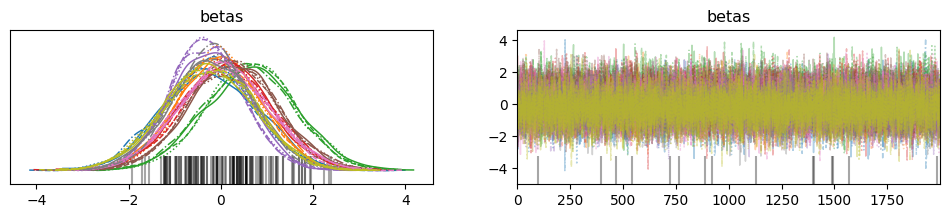

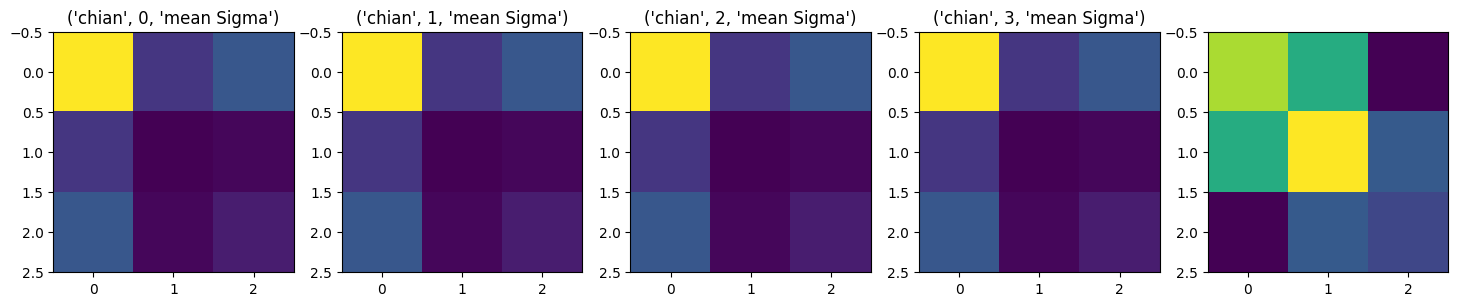

In [29]:
# Scenario 2: Downsample observations (n=10, p=3, m=3)
n2 = 10
p2 = 3
m2 = 3

# Randomly select 10 indices out of 20
np.random.seed(42)
indices2 = np.random.choice(np.arange(20), size=n2, replace=False)
X2 = X_full_scaled[indices2, :]
y2 = y_full[indices2, :]
a_cov = np.cov(X2.T)


# You can run your model on any of these scenarios to explore the effect of changing n, p, m.
# For demonstration, we'll run the model on Scenario 1 (the full Linnerud dataset).
n, p, m = n2, p2, m2
X = X2
y = y2

with pm.Model() as model:
    # Prior for the Cholesky factor of the residual covariance matrix using an LKJ prior.
    # Note: We use the packed representation.
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                       sd_dist=pm.Exponential.dist(1.0, shape=m),
                                       compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    # Prior for the regression coefficients (p x m)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Deterministic reconstruction of the covariance matrix (for diagnostics)
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))

    # Likelihood: outcomes modeled as multivariate normal with mean = X @ betas and covariance from L
    y_obs = pm.MvNormal("y_obs", mu=pm.math.dot(X, betas), chol=L, observed=y)

    # Sample from the posterior
    idata_scenario_2 = pm.sample(2000, chains=4)


az.plot_trace(idata_scenario_2,var_names='betas');

fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata_scenario_2.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

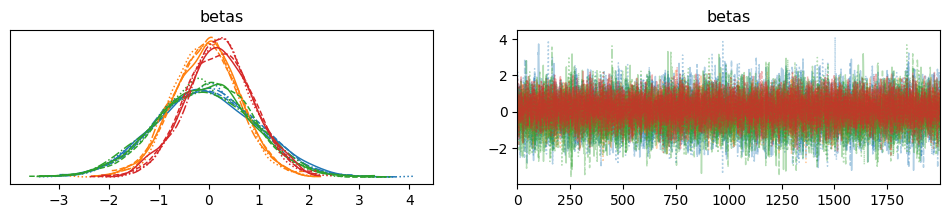

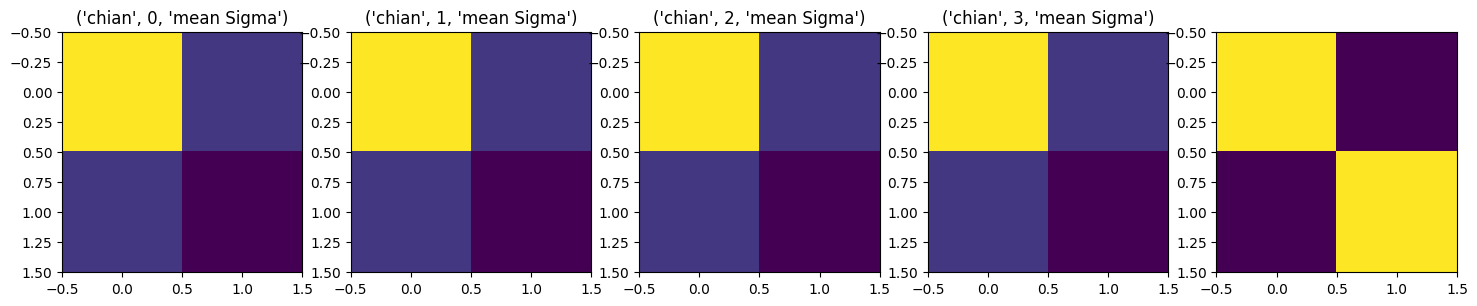

In [30]:
# Scenario 3: Reduce predictors and outcomes (n=20, p=2, m=2)
# For example, select the first two predictors and outcomes
n3 = 20
p3 = 2
m3 = 2
X3 = X_full_scaled[:, :p3]
y3 = y_full[:, :m3]
a_cov = np.cov(X3.T)

n, p, m = n3, p3, m3
X = X3
y = y3


with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                       sd_dist=pm.Exponential.dist(1.0, shape=m),
                                       compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    # Prior for the regression coefficients (p x m)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Deterministic reconstruction of the covariance matrix (for diagnostics)
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))

    # Likelihood: outcomes modeled as multivariate normal with mean = X @ betas and covariance from L
    y_obs = pm.MvNormal("y_obs", mu=pm.math.dot(X, betas), chol=L, observed=y)

    # Sample from the posterior
    idata_scenario_3 = pm.sample(2000, chains=4)


az.plot_trace(idata_scenario_3,var_names='betas');

fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata_scenario_3.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))


In [31]:
summary_stats_scenario_1 = az.summary(idata_scenario_1,var_names=['betas'], round_to=2)
summary_stats_scenario_1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.11,0.97,-1.92,1.70,0.01,0.01,10677.71,5645.86,1.0
"betas[0, 1]",-0.28,0.58,-1.39,0.79,0.01,0.01,9910.70,6427.54,1.0
"betas[0, 2]",0.45,0.92,-1.27,2.18,0.01,0.01,11239.28,5848.96,1.0
"betas[1, 0]",-0.14,0.97,-1.98,1.70,0.01,0.01,11028.71,5589.67,1.0
"betas[1, 1]",-0.45,0.63,-1.60,0.76,0.01,0.01,7346.01,6080.19,1.0
"betas[1, 2]",0.63,0.94,-1.09,2.41,0.01,0.01,10238.57,5567.51,1.0
"betas[2, 0]",-0.15,0.97,-1.90,1.70,0.01,0.01,9514.56,5239.51,1.0
"betas[2, 1]",0.52,0.59,-0.58,1.65,0.01,0.01,8679.36,6197.87,1.0
"betas[2, 2]",0.06,0.93,-1.69,1.79,0.01,0.01,11934.22,5820.04,1.0


In [32]:
summary_stats_scenario_2 = az.summary(idata_scenario_2,var_names=['betas'], round_to=2)
summary_stats_scenario_2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.25,1.01,-2.15,1.60,0.01,0.01,9398.13,4731.69,1.0
"betas[0, 1]",-0.03,0.89,-1.61,1.75,0.01,0.01,7704.66,5095.08,1.0
"betas[0, 2]",0.63,0.98,-1.20,2.45,0.01,0.01,8654.62,5267.76,1.0
"betas[1, 0]",0.11,0.98,-1.73,1.95,0.01,0.01,10086.28,5447.18,1.0
"betas[1, 1]",-0.29,0.81,-1.84,1.18,0.01,0.01,9166.72,5777.22,1.0
"betas[1, 2]",0.26,0.95,-1.58,2.01,0.01,0.01,9906.46,5080.49,1.0
"betas[2, 0]",0.06,0.99,-1.80,1.94,0.01,0.01,8133.59,5352.66,1.0
"betas[2, 1]",-0.18,0.89,-1.83,1.52,0.01,0.01,9926.15,5710.04,1.0
"betas[2, 2]",-0.25,0.99,-2.05,1.63,0.01,0.01,10563.17,5424.65,1.0


In [33]:
summary_stats_scenario_3 = az.summary(idata_scenario_3,var_names=['betas'], round_to=2)
summary_stats_scenario_3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.05,0.99,-1.94,1.74,0.01,0.01,7300.99,4742.07,1.0
"betas[0, 1]",-0.05,0.66,-1.33,1.14,0.01,0.01,7561.90,5603.70,1.0
"betas[1, 0]",-0.09,0.96,-1.93,1.70,0.01,0.01,8236.89,5266.23,1.0
"betas[1, 1]",0.20,0.67,-1.03,1.53,0.01,0.01,8022.26,4674.49,1.0


Comparing Scenarios:

Scenario 1 (n=20, p=3, m=3): Provides stable estimates with high effective sample sizes and robust convergence diagnostics. It uses all available information from the Linnerud dataset.

Scenario 2 (n=10, p=3, m=3): Shows increased uncertainty and lower ESS due to fewer observations. Although convergence remains good, the loss of data weakens the inference.

Scenario 3 (n=20, p=2, m=2): Simplifies the model and maintains good diagnostics, but sacrifices some of the information contained in all 3 predictors and outcomes.

Based on our experiments, the full dataset (Scenario 1: n = 20, p = 3, m = 3) is "reasonably small" yet sufficiently informative for an actual analysis. It offers robust posterior estimates and excellent sampling diagnostics, making it the preferred configuration for our Bayesian multivariate regression analysis on the Linnerud dataset.


# Question 3

I used the Titanic Dataset. Here, I will be using two binary outcomes ("survived" and "alone") with 4 predictors.

In [34]:
df = sns.load_dataset('titanic')

# For this analysis, we focus on two binary outcomes:
#   - "survived": already available (0 = did not survive, 1 = survived)
#   - "alone": whether the passenger was traveling alone; convert to int (False=0, True=1)
df = df.dropna(subset=['fare', 'pclass', 'sibsp', 'parch', 'survived', 'alone'])
df['alone'] = df['alone'].astype(int)

# Select predictors and outcomes
predictors = ['fare', 'pclass', 'sibsp', 'parch']
outcomes = ['survived', 'alone']

# Downsample to a reasonably small dataset (n = 200)
df_small = df.sample(n=200, random_state=42)

# Extract predictors X and outcomes y
X = df_small[predictors].values     # shape: (n, p)
y = df_small[outcomes].values.astype(float)  # shape: (n, m)

# Standardize predictors to improve sampling efficiency
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3 Scenarios to consider

1. Full dataset (n=200, p=4, m=2)
2. Downsample observations (n=100, p=4, m=2)
3. Reduce predictors (n=200, p=2, m=2)

In [35]:
# scenario 1
n1 = 200
p1 = 4
m1 = 2
indices1 = np.arange(n1)

X1 = X_scaled[indices1, :]
y1 = y[indices1, :]


n, p, m = n1, p1, m1
X = X1
y = y1



with pm.Model() as model:
    # Regression coefficients: (p x m) matrix


    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Prior for the Cholesky factor of the latent residual covariance matrix.
    # We use an LKJ prior with an Exponential prior for the scales.
    # Note: pm.LKJCholeskyCov returns a tuple; we unpack and use only the packed part.
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                       sd_dist=pm.Exponential.dist(1.0, shape=m),
                                       compute_corr=False)

    L = pm.expand_packed_triangular(m, packed_L)

    # Latent variables: z ~ MVN(mean = X_scaled @ betas, covariance defined by L)
    z = pm.MvNormal("z", mu=pm.math.dot(X1, betas), chol=L, shape=(n, m))

    # Link function: map latent variable to probability using the inverse probit
    p_y = pm.math.invprobit(z)

    # Observed binary outcomes modeled with a Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p_y, observed=y)

    # Sample from the posterior
    idata_scenario_1 = pm.sample(2000, chains=4)

Output()

ERROR:pymc.stats.convergence:There were 3593 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [36]:
# scenario 2
n2 = 100
p2 = 4
m2 = 2

np.random.seed(42)
indices2 = np.random.choice(np.arange(n2), size=n2, replace=False)
X2 = X_scaled[indices2, :]
y2 = y[indices2, :]

n, p, m = n2, p2, m2
X = X2
y = y2



with pm.Model() as model:
    # Regression coefficients: (p x m) matrix


    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Prior for the Cholesky factor of the latent residual covariance matrix.
    # We use an LKJ prior with an Exponential prior for the scales.
    # Note: pm.LKJCholeskyCov returns a tuple; we unpack and use only the packed part.
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                       sd_dist=pm.Exponential.dist(1.0, shape=m),
                                       compute_corr=False)

    L = pm.expand_packed_triangular(m, packed_L)

    # Latent variables: z ~ MVN(mean = X_scaled @ betas, covariance defined by L)
    z = pm.MvNormal("z", mu=pm.math.dot(X, betas), chol=L, shape=(n, m))

    # Link function: map latent variable to probability using the inverse probit
    p_y = pm.math.invprobit(z)

    # Observed binary outcomes modeled with a Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p_y, observed=y)

    # Sample from the posterior
    idata_scenario_2 = pm.sample(2000, chains=4)

Output()

ERROR:pymc.stats.convergence:There were 3626 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [46]:
X2.shape
X3.shape
y1.shape

(200, 2)

In [48]:
# scenario 3
n3 = 200
p3 = 2
m3 = 2

y = df_small[outcomes].values.astype(float)  # shape: (n, m)

X3 = X_scaled[:, :p3]
y3 = y[indices3, :]


n, p, m = n3, p3, m3
X = X3
y = y3



with pm.Model() as model:
    # Regression coefficients: (p x m) matrix


    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Prior for the Cholesky factor of the latent residual covariance matrix.
    # We use an LKJ prior with an Exponential prior for the scales.
    # Note: pm.LKJCholeskyCov returns a tuple; we unpack and use only the packed part.
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                       sd_dist=pm.Exponential.dist(1.0, shape=m),
                                       compute_corr=False)

    L = pm.expand_packed_triangular(m, packed_L)

    # Latent variables: z ~ MVN(mean = X_scaled @ betas, covariance defined by L)
    z = pm.MvNormal("z", mu=pm.math.dot(X, betas), chol=L, shape=(n, m))

    # Link function: map latent variable to probability using the inverse probit
    p_y = pm.math.invprobit(z)

    # Observed binary outcomes modeled with a Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p_y, observed=y)

    # Sample from the posterior
    idata_scenario_3 = pm.sample(2000, chains=4)

Output()

ERROR:pymc.stats.convergence:There were 2792 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [55]:
summary_stats_scenario_1 = az.summary(idata_scenario_1,var_names=['betas'], round_to=2)
summary_stats_scenario_1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.24,0.20,-0.17,0.64,0.01,0.01,151.88,659.10,1.46
"betas[0, 1]",-0.18,0.21,-0.61,0.13,0.05,0.04,20.06,784.84,1.14
"betas[1, 0]",-0.96,0.33,-1.37,-0.34,0.10,0.08,12.69,195.64,1.25
"betas[1, 1]",0.34,0.31,-0.24,0.72,0.10,0.08,9.95,79.59,1.33
"betas[2, 0]",0.03,0.22,-0.47,0.28,0.06,0.05,11.96,28.63,1.24
"betas[2, 1]",-3.41,0.55,-4.08,-2.30,0.21,0.16,7.92,12.88,1.47
"betas[3, 0]",0.17,0.18,-0.14,0.54,0.03,0.02,43.79,832.68,1.17
"betas[3, 1]",-2.30,0.40,-3.05,-1.51,0.06,0.04,39.06,17.89,1.55


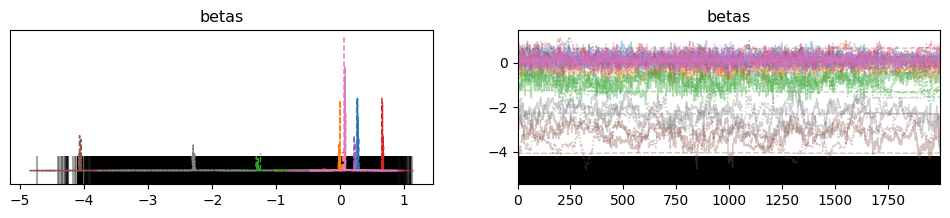

In [56]:
az.plot_trace(idata_scenario_1,var_names='betas');

In [52]:
summary_stats_scenario_2 = az.summary(idata_scenario_2,var_names=['betas'], round_to=2)
summary_stats_scenario_2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.74,0.39,0.02,1.44,0.04,0.03,103.74,294.32,1.03
"betas[0, 1]",-0.63,0.50,-1.54,0.22,0.03,0.02,260.07,594.98,1.02
"betas[1, 0]",-0.55,0.38,-1.29,0.14,0.04,0.03,132.42,172.04,1.03
"betas[1, 1]",-0.00,0.38,-0.81,0.66,0.03,0.02,188.22,117.76,1.04
"betas[2, 0]",-0.26,0.32,-0.81,0.32,0.05,0.05,75.47,38.46,1.04
"betas[2, 1]",-2.53,0.46,-3.42,-1.70,0.04,0.03,167.82,307.56,1.03
"betas[3, 0]",0.09,0.29,-0.44,0.65,0.03,0.02,130.33,608.38,1.03
"betas[3, 1]",-2.16,0.48,-2.94,-1.23,0.07,0.05,45.93,499.22,1.07


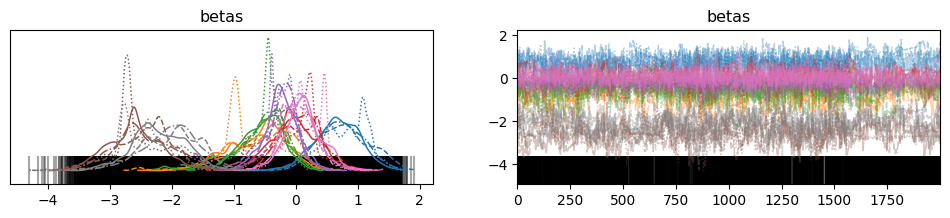

In [57]:
az.plot_trace(idata_scenario_2,var_names='betas');

In [53]:
summary_stats_scenario_3 = az.summary(idata_scenario_3,var_names=['betas'], round_to=2)
summary_stats_scenario_3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.29,0.20,-0.08,0.68,0.02,0.01,153.65,610.36,1.04
"betas[0, 1]",-1.03,0.31,-1.62,-0.46,0.06,0.04,31.20,111.85,1.10
"betas[1, 0]",-0.66,0.28,-1.20,-0.18,0.07,0.05,15.81,40.90,1.19
"betas[1, 1]",-0.27,0.22,-0.71,0.09,0.02,0.02,99.96,210.65,1.04


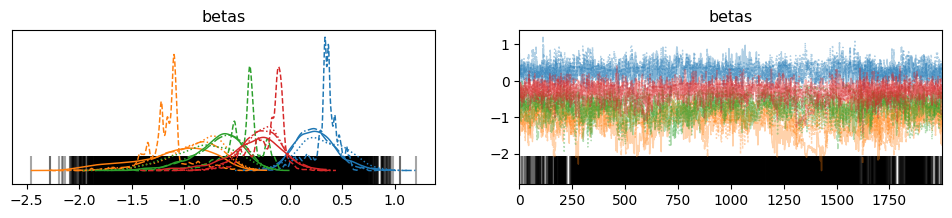

In [58]:
az.plot_trace(idata_scenario_3,var_names='betas');